<a href="https://colab.research.google.com/github/ChenYP-1982/Clusterizacao-RFM/blob/main/Clusteringecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business understanding
* A Noah S.A. é um e-commerce que vende produtos de todos os segmentos (Cozinha, eletrônico, móveis, telefonia e etc).


No último ano, na contramão dos concorrentes, ela expandiu sua base de clientes em 200%. Com essa expansão, o C-Level enxergou a oportunidade de levantar os indicadores de RFV.

Com isso foi pedido para a equipe de analista de dados e junto com a que cientista de dados um maior entendimento sobre as caracteristicas dos consumidores e conseguindo assim ter um  abordagem mais coerente e concisa para cada grupo de clientes

RFV
Métrica de vendas onde:
1. Recência (R) – Tempo que o cliente realizou a última compra (Em dias)
2. Frequência (F) – Quantidade de compras realizadas pelo cliente
3. Valor (V) – Valor do Ticket Médio gasto pelo cliente

#####################################################################################

Para a entrega do projeto ao Stakeholder, seguira algumas etapas

1. Análise Descritiva

2. Análise Exploratória

3. Modelagem de base para clusterização

4. Testar os diversos algoritmos de clusterização para ver qual melhor se adapta a necessidade

4. Discutir os insights e possíveis ações que podem ser tomadas



In [153]:
%%capture

!pip install sidetable
!pip install missingno


In [154]:
#data wrangling e EDA
import pandas as pd
import numpy as np
import sidetable as stb
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#
from sklearn.mixture import GaussianMixture

from sklearn.cluster import (KMeans,
                             AgglomerativeClustering)

from sklearn.metrics import (silhouette_score,
                             davies_bouldin_score,
                             calinski_harabasz_score)

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from datetime import date
import warnings
from yellowbrick.cluster import ( kelbow_visualizer,
                                 silhouette_visualizer)

warnings.filterwarnings("ignore")

In [155]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)


In [156]:
def check_df(df:pd.DataFrame, head = 5):
    '''
    funcao gerada para printar no output o shape do nosso dataset, a info, as 5 primeiras linhas,
    informacoes sobre valores nulos, a distirbuicao dos nossos dados e os quantiles
    :param dataset : Pandas DataFrame
    :param head :int , default =5. Numero de linhas que vai ser
    mostrado
    '''
    print('#'*30 + 'Shape of Dataset' + '#'*30, end = '\n')
    print(df.shape, end = '\n')
    print('#'*30 + 'General informations about to Dataset' + '#'*30, end = '\n')
    print(df.info(), end = '\n')
    print('#'*30 + 'First 5 Lines Of Dataset' + '#'*30, end = '\n')
    print(df.head(head), end = '\n'*2)
    print(print('#'*30 + 'Is duplicates' + '#'*30, end = '\n'))
    print(df.duplicated().sum(), end = '\n'*2)
    print(print('#'*30 + 'Is Nan data' + '#'*30, end = '\n'))
    print(df.isna().sum(), end = '\n'*2)
    print('#'*30 + 'Quantiles of Numerical Features' + '#'*30, end ='\n')
    print(df.describe([0,0.10, 0.25, 0.50,0.75,0.99]).T, end = '\n')


######################################################################

def top_clientes(df:pd.DataFrame, n=10)->pd.DataFrame:
  '''
  Funcao que retorna em forma de pandas Dataframe osclientes que mais gastam
  na nossa plataforma
  param df: pandas dataframe
  param n: integer, default=10
  '''
  df=(df.groupby("id_cliente").agg(ticket_medio=("preco_total","mean"))
  .reset_index()
  .sort_values(by="ticket_medio", ascending=False)
  .head(n))
  return df


###############################################################################

def top_clientes_pedidos(df:pd.DataFrame, n=10)->pd.DataFrame:
  '''
  Funcao que retorna uma pandas Dataframe contendo clientes que fizeram mais
  pedidos
  param df: pandas dataframe
  param n:interger, default=10
  '''
  df=(df.groupby("id_cliente").agg(total_pedidos=("quantidade","sum"))
  .reset_index()
  .sort_values("total_pedidos", ascending=False)
  .head(n)
  )
  return df

#######################################################################


def top_product_income(df:pd.DataFrame, n=10)->pd.DataFrame:
  '''
  Funcao que retorna os top 10  produtos com maiores valores em vendas
  param df: pandas dataframe
  param n: interger, default=10

  '''

  df=(df.groupby("descricao").agg(preco_total=("preco_total","sum"))
  .reset_index()
  .sort_values(by="preco_total", ascending=False)
  .head(n))
  return df


##############################################################################

def top_product_quatity(df:pd.DataFrame, n=10)->pd.DataFrame:
  '''
  Funcao que retorna um pandas dataframe com os top 10 produtos mais
  vendidos em quantidade
  param df: pandas dataframe
  param n: interge, default=10
  '''
  df=(df.groupby("descricao").agg(quantidade_vendida=("quantidade","sum"))
  .reset_index()
  .sort_values(by="quantidade_vendida", ascending=False)
  .head(n))
  return df

#####################################################################################

def create_horizontal_barplot(df:pd.DataFrame, x_col, y_col, palette="gray", title="", xlabel="", ylabel="", order=None):
    """
    Grafico de barras em seaborn.

    Parameters:
    - data: pandas DataFrame .
    - x_col: nome da coluna for the x-axis.
    - y_col: nome da coluna for the y-axis.
    - palette: Cor da sua paleta de cor, default = "gray".
    - title: Titulo para o grafico the plot.
    - xlabel: Label  para x-axis.
    - ylabel: Label para y-axis.
    - order: Order para bars (optional).

    Returns:
    - None
    """
    # ordenacao do nosso dataset
    if order is not None:
        data = data.sort_values(by=x_col, ascending=False)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    sns.barplot(x=df[x_col], y=df[y_col], ax=ax, palette=palette, orient='h', order=order, zorder=10)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle='--', zorder=0)
    plt.show()



#################################################################################################

def calculate_rfm(df:pd.DataFrame, recency_col, frequency_col, monetary_col, reference_date)->pd.DataFrame:
    """
    Retorna um pandas dataframe com as colunas de Frequency, Rencency e Monetary.

    Parametros:
    - data: pandas dataframe.
    - recency_col: coluna para calculo da recencia->data compra.
    - frequency_col: coluna para calculo da frequencia->id_cliente.
    - monetary_col: coluna com vaor de compra gasto-> valor total.
    - reference_date: referencia da data para o calculo de recencia.


    """
    rfm = (df.groupby("id_cliente").agg(
        R=(recency_col, lambda x: (reference_date - x.max()).days),
        F=(frequency_col, 'count'),
        V=(monetary_col, 'mean'),
    ))

    # Rename the columns
    rfm.columns = ['R', 'F', 'M']

    return rfm





In [157]:
df=pd.read_csv("/content/ecommerce(1).csv", encoding="ISO-8859-1",header=0,sep=";")
df.head(3)



,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,06/06/2021 08:26,6,2.55,17850.0,16/08/2021
1,536366,HAND WARMER UNION JACK,06/06/2021 08:28,6,1.85,17850.0,16/08/2021
2,536367,ASSORTED COLOUR BIRD ORNAMENT,06/06/2021 08:34,32,1.69,13047.0,14/05/2022


# Data Understanding

In [158]:
'''
Atraves da nossa descricao basica do dataset ja conseguimos identificar alguns
valores NaN para Descricao,  ID_cliente, e valores negativos para preco_unitario

'''
check_df(df)

##############################Shape of Dataset##############################
(25832, 7)
##############################General informations about to Dataset##############################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25832 entries, 0 to 25831
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_pedido       25832 non-null  object 
 1   descricao       24378 non-null  object 
 2   data_pgto       25832 non-null  object 
 3   quantidade      25832 non-null  int64  
 4   preco_unitario  25832 non-null  float64
 5   id_cliente      22190 non-null  float64
 6   ultima_compra   25832 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.4+ MB
None
##############################First 5 Lines Of Dataset##############################
  id_pedido                           descricao         data_pgto  quantidade  \
0    536365  WHITE HANGING HEART T-LIGHT HOLDER  06/06/2021 08:26   

In [159]:
df.duplicated

<bound method DataFrame.duplicated of       id_pedido                            descricao         data_pgto  \
0        536365   WHITE HANGING HEART T-LIGHT HOLDER  06/06/2021 08:26   
1        536366               HAND WARMER UNION JACK  06/06/2021 08:28   
2        536367        ASSORTED COLOUR BIRD ORNAMENT  06/06/2021 08:34   
3        536368             JAM MAKING SET WITH JARS  06/06/2021 08:34   
4        536369             BATH BUILDING BLOCK WORD  06/06/2021 08:35   
...         ...                                  ...               ...   
25827    581583              LUNCH BAG RED RETROSPOT  14/06/2022 12:23   
25828    581584     RED FLOCK LOVE HEART PHOTO FRAME  14/06/2022 12:25   
25829    581585       BLACK TEA TOWEL CLASSIC DESIGN  14/06/2022 12:31   
25830    581586  LARGE CAKE STAND  HANGING STRAWBERY  14/06/2022 12:49   
25831    581587             CIRCUS PARADE LUNCH BOX   14/06/2022 12:50   

       quantidade  preco_unitario  id_cliente ultima_compra  
0          

In [160]:
# Entendendo percentual de valores NaN que existem no nosso dataset

df.stb.missing()

,missing,total,percent
id_cliente,3642,25832,14.098792
descricao,1454,25832,5.628678
id_pedido,0,25832,0.000000
data_pgto,0,25832,0.000000
quantidade,0,25832,0.000000
preco_unitario,0,25832,0.000000
ultima_compra,0,25832,0.000000


In [161]:
'''
existem outras inconsistencias nos nossos dados, alem dos valores de preco unitario temos tambem
#N/D para ultima compra, valores unitarios 0.0
'''
df.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
quantidade,25832,137,1,5325,136,1
ultima_compra,25832,305,#N/D,3642,16/09/2021,1
preco_unitario,25832,633,0.0,2045,9.89,1
descricao,24378,3003,Manual,328,GREY ACRYLIC FACETED BANGLE,1
id_cliente,22190,4372,14911.0,248,17836.0,1
data_pgto,25832,23177,13/11/2021 15:05,6,13/03/2022 10:50,1
id_pedido,25832,25832,536365,1,536365,1


## Tratamento dos valores NaN, valores fora do padrao, e #N/D para a coluna data

<Axes: >

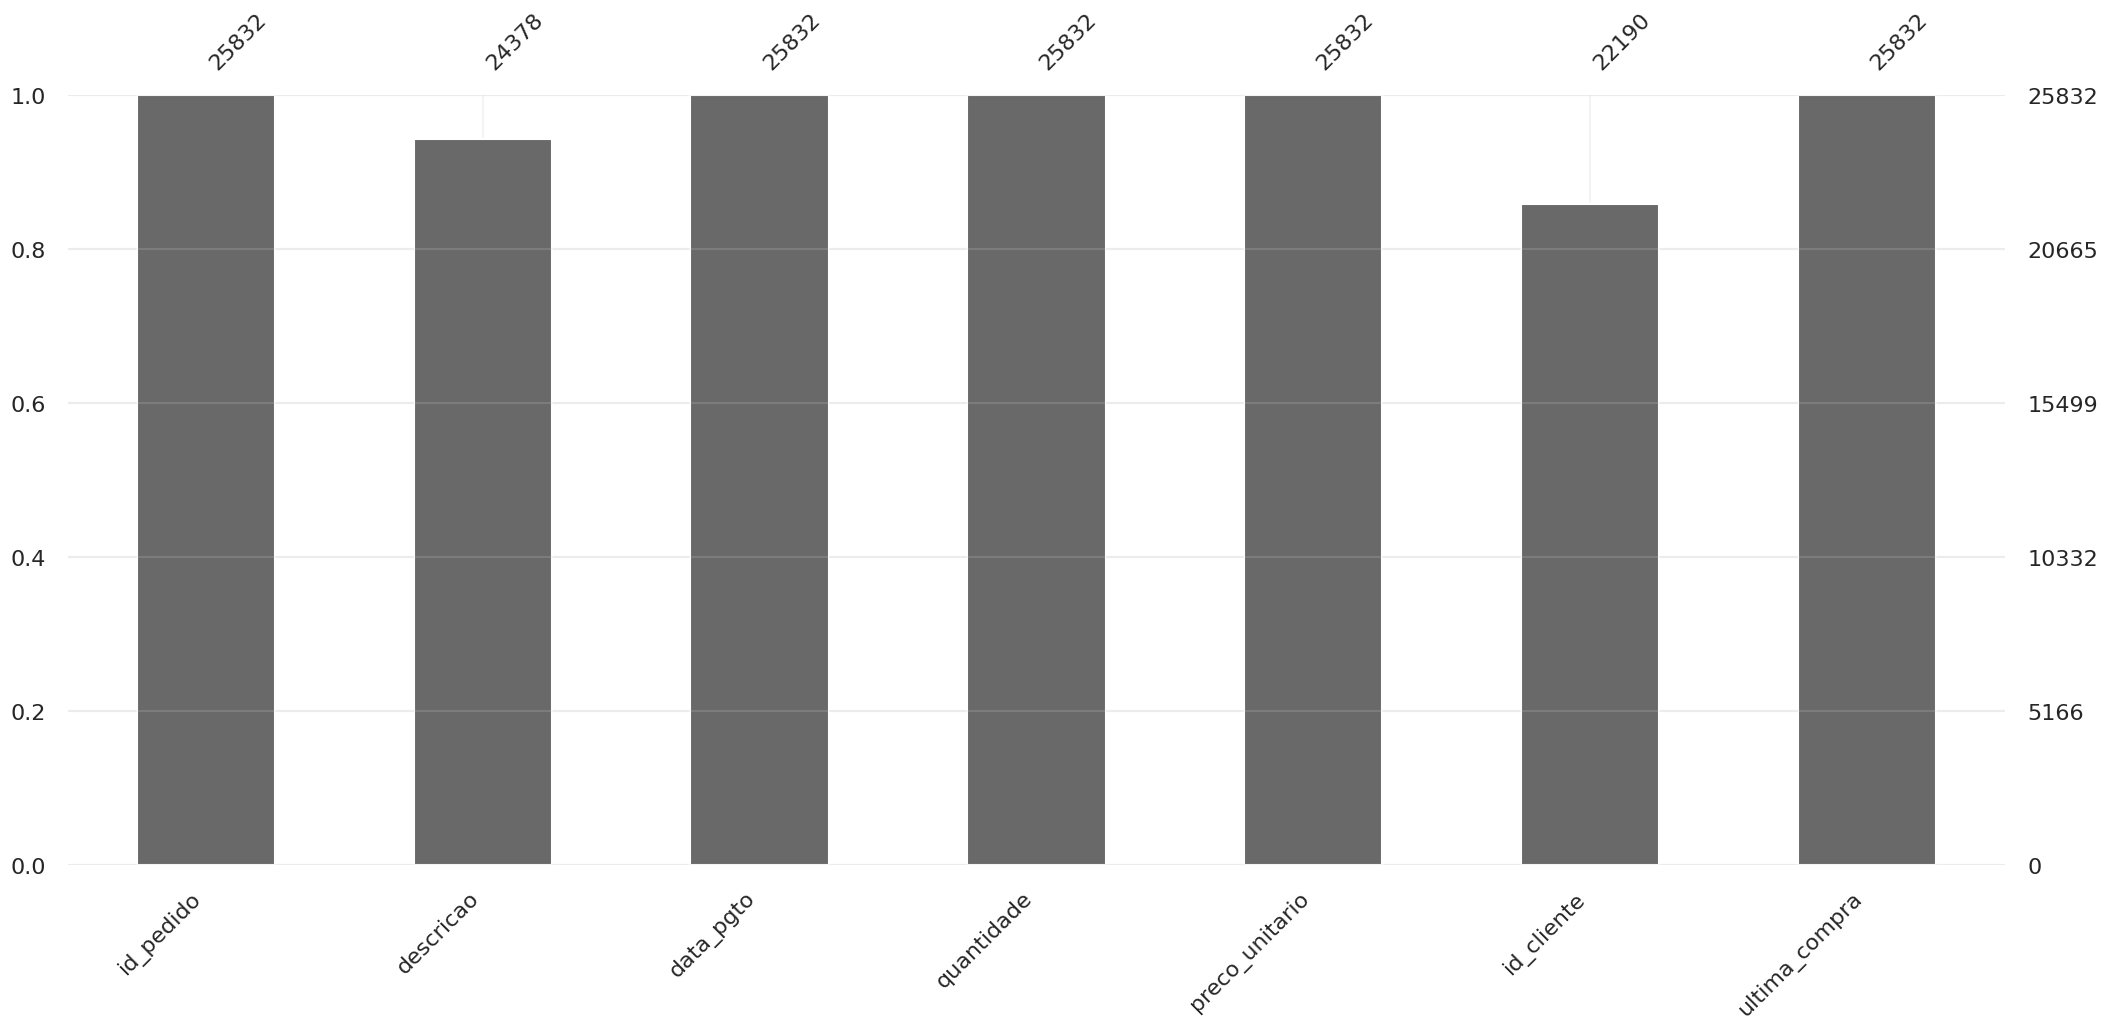

In [162]:
#representacao dos nosso valores faltantes
msno.bar(df)

In [163]:
# visualizacao tabular dos nosss dados faltantes

df[df.isna().any(axis=1)]

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
46,536414,NaN,06/06/2021 11:52,56,0.00,NaN,#N/D
89,536544,DECORATIVE ROSE BATHROOM BOTTLE,06/06/2021 14:32,1,2.51,NaN,#N/D
90,536545,NaN,06/06/2021 14:32,1,0.00,NaN,#N/D
91,536546,NaN,06/06/2021 14:33,1,0.00,NaN,#N/D
92,536547,NaN,06/06/2021 14:33,1,0.00,NaN,#N/D
...,...,...,...,...,...,...,...
25748,581435,4 SKY BLUE DINNER CANDLES,13/06/2022 16:14,1,1.25,NaN,#N/D
25752,581439,IVORY WICKER HEART SMALL,13/06/2022 16:30,4,1.25,NaN,#N/D
25800,581492,SET 36 COLOUR PENCILS LOVE LONDON,14/06/2022 10:03,2,2.46,NaN,#N/D
25805,581497,WOODLAND CHARLOTTE BAG,14/06/2022 10:23,33,2.46,NaN,#N/D


In [164]:
#como o RFM é calculado em cima do ID do cliente optamos em retirar os IDs faltantes.

df.dropna(subset="id_cliente", inplace=True)

# Eliminando os valores Nan da nossa base ID cliente eliminamos os Nan das descricao tambem

df[df.isna().any(axis=1)]

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra


In [165]:
#analisando o valor #N/D da coluna ultima_compra

df.loc[df.ultima_compra=="#N/D"]

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra


In [166]:
df.head(1)

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,06/06/2021 08:26,6,2.55,17850.0,16/08/2021


In [167]:
# Como os valores de data estao em forma de object, sera realizado casting das nossas datas
df["ultima_compra"]=pd.to_datetime(df["ultima_compra"], format="%d/%m/%Y")
df["data_pgto"]=pd.to_datetime(df["data_pgto"], format="%d/%m/%Y %H:%M")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22190 entries, 0 to 25831
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_pedido       22190 non-null  object        
 1   descricao       22190 non-null  object        
 2   data_pgto       22190 non-null  datetime64[ns]
 3   quantidade      22190 non-null  int64         
 4   preco_unitario  22190 non-null  float64       
 5   id_cliente      22190 non-null  float64       
 6   ultima_compra   22190 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 1.4+ MB


In [168]:
#analisando valores de vendas 0
df.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.90,0.99])

,quantidade,preco_unitario,id_cliente
count,22190.000000,22190.000000,22190.000000
mean,18.383867,11.985803,15238.498738
std,28.162886,293.318277,1733.149624
min,1.000000,0.000000,12346.000000
1%,1.000000,0.190000,12417.000000
10%,1.000000,0.650000,12883.900000
25%,2.000000,1.250000,13755.000000
50%,8.000000,2.100000,15136.000000
75%,20.000000,4.950000,16746.000000
90%,48.000000,8.500000,17696.000000


In [169]:
#optamos em eliminar os valores 0
df=df.loc[~(df.preco_unitario==0)]

## Feature engineering

## Criando coluna extra

In [170]:
df["preco_total"]=df["quantidade"]*df["preco_unitario"]
df.head(10)

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra,preco_total
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850.0,2021-08-16,15.30
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850.0,2021-08-16,11.10
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047.0,2022-05-14,54.08
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047.0,2022-05-14,25.50
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047.0,2022-05-14,17.85
5,536370,ALARM CLOCK BAKELIKE PINK,2021-06-06 08:45:00,24,3.75,12583.0,2022-06-12,90.00
6,536371,PAPER CHAIN KIT 50'S CHRISTMAS,2021-06-06 09:00:00,80,2.55,13748.0,2022-03-11,204.00
7,536372,HAND WARMER RED POLKA DOT,2021-06-06 09:01:00,6,1.85,17850.0,2021-08-16,11.10
8,536373,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 09:02:00,6,2.55,17850.0,2021-08-16,15.30
9,536374,VICTORIAN SEWING BOX LARGE,2021-06-06 09:09:00,32,10.95,15100.0,2021-07-19,350.40


## RFM

Métrica de vendas onde:
1. Recência (R) – Tempo que o cliente realizou a última compra (Em dias)
2. Frequência (F) – Quantidade de compras realizadas pelo cliente
3. Valor (V) – Valor do Ticket Médio gasto pelo cliente

In [171]:

#calculando o RFM

rfm = calculate_rfm(df, 'ultima_compra', 'id_cliente', 'preco_total', pd.Timestamp("2023-12-31"))

rfm

,R,F,M
id_cliente,,,
12346.0,890,2,14.040000
12347.0,567,7,23.308571
12348.0,640,4,82.840000
12349.0,583,1,15.000000
12350.0,875,1,25.200000
...,...,...,...
18280.0,842,1,23.700000
18281.0,745,1,5.040000
18282.0,572,3,15.166667


## Distribuicao viz

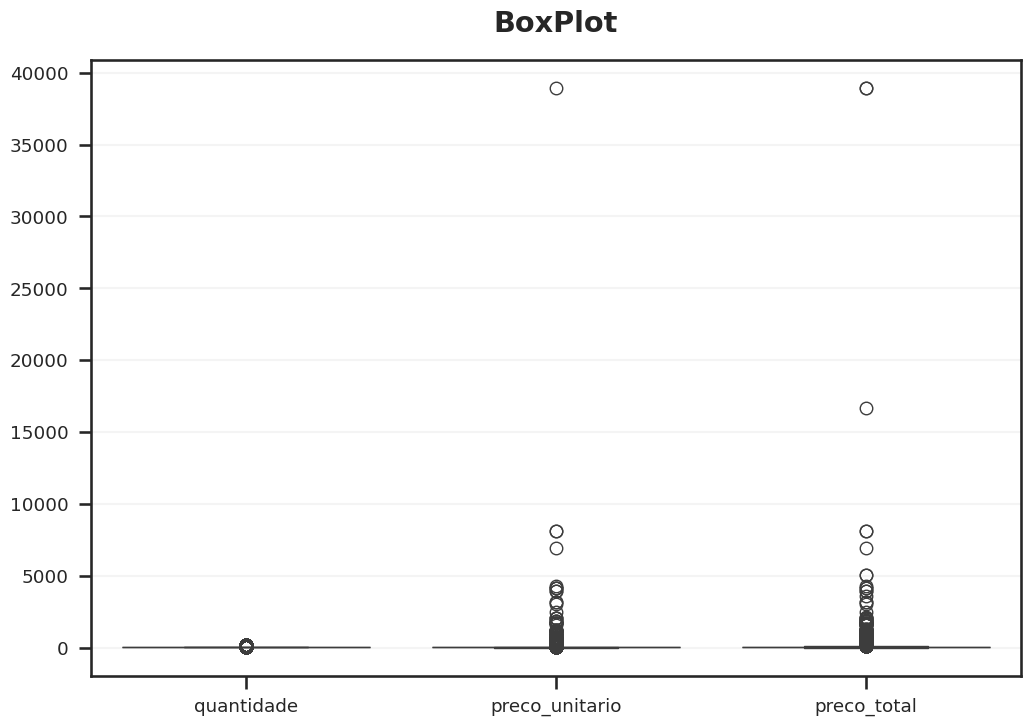

In [172]:
sns.boxplot(data=df[["quantidade","preco_unitario","preco_total"]])
plt.title("BoxPlot")
plt.show()

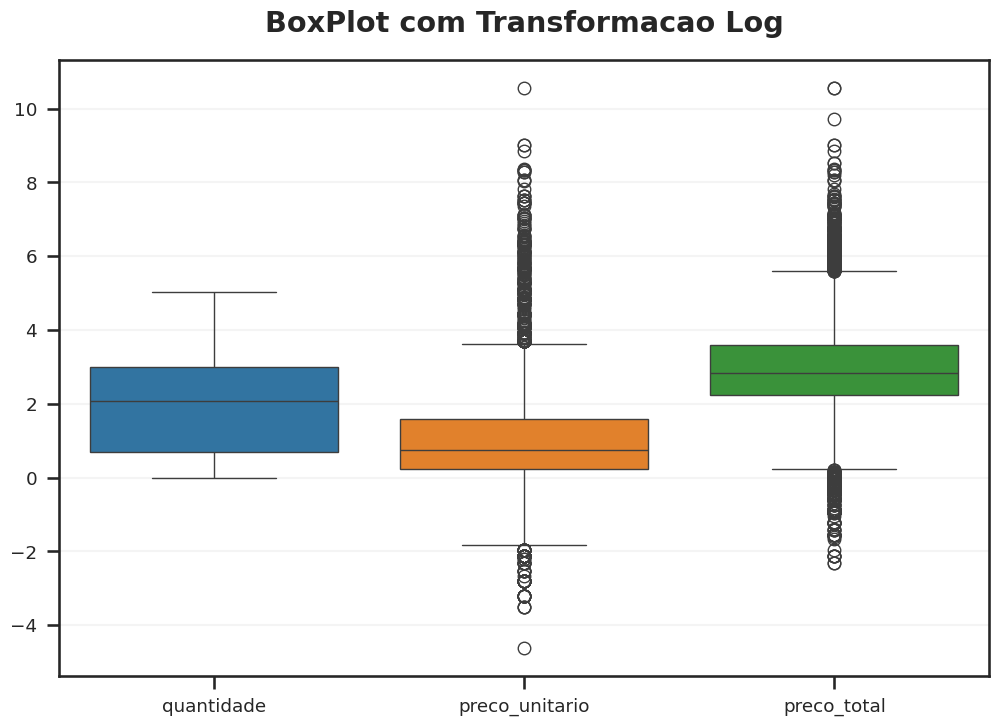

In [173]:
sns.boxplot(data=np.log(df[["quantidade","preco_unitario","preco_total"]]))
plt.title("BoxPlot com Transformacao Log")
plt.show()

<Axes: >

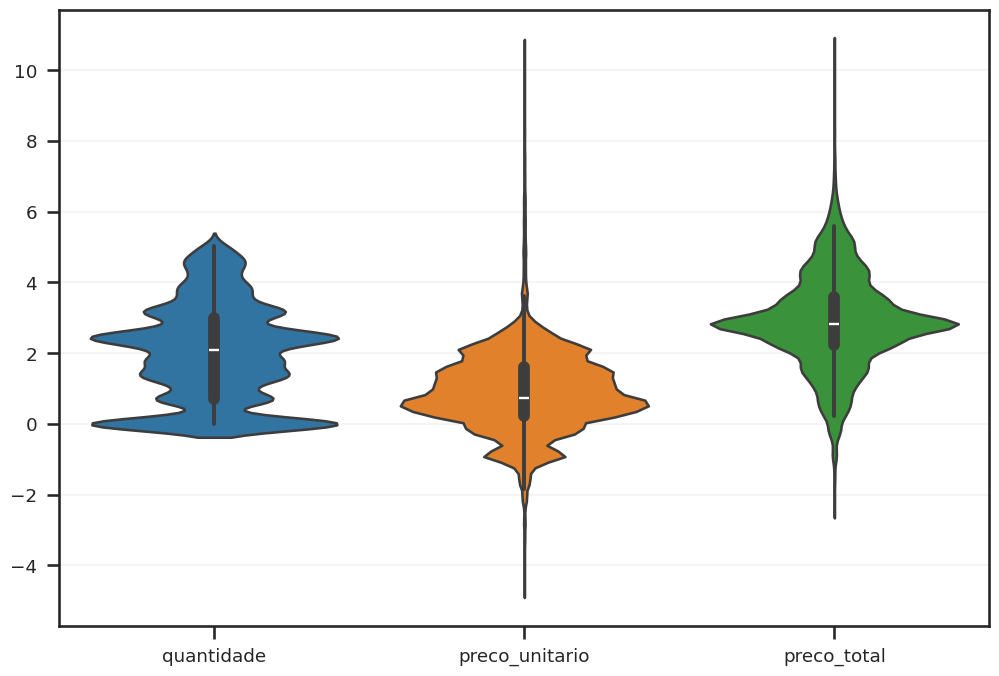

In [174]:
sns.violinplot(data=np.log(df[["quantidade","preco_unitario","preco_total"]]))

In [175]:
df[["quantidade","preco_unitario","preco_total"]].corr()

,quantidade,preco_unitario,preco_total
quantidade,1.000000,-0.020416,0.118988
preco_unitario,-0.020416,1.000000,0.726857
preco_total,0.118988,0.726857,1.000000




## Comportamento do nosso clientes

In [176]:
# top 10 clientes em valores gasto

topclientes=top_clientes(df)
topclientes.style.background_gradient(cmap="Reds")
topclientes

,id_cliente,ticket_medio
2026,15098.0,15881.250
154,12536.0,5029.192
3755,17448.0,4287.630
4044,17846.0,2033.100
2235,15369.0,1592.490
328,12744.0,1261.444
931,13587.0,1249.400
1105,13829.0,1224.000
125,12503.0,1126.000
2103,15197.0,1102.450


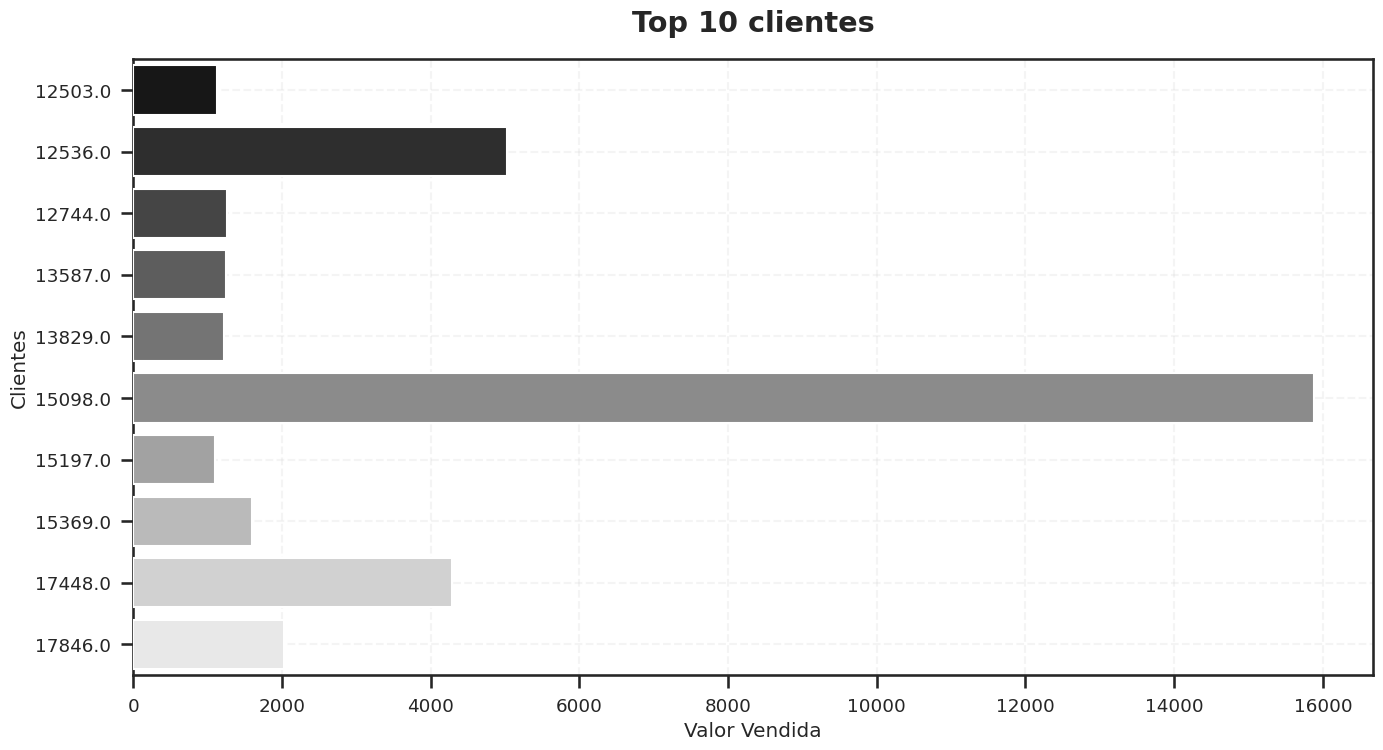

In [177]:
create_horizontal_barplot( topclientes, x_col='ticket_medio', y_col='id_cliente',
                          title="Top 10 clientes",
                          xlabel="Valor Vendida", ylabel="Clientes", order=None)

In [178]:
# os top 10 clientes que mais fizeram pedidos

topclientespedidos=top_clientes_pedidos(df)

topclientespedidos.style.background_gradient(cmap='Reds')


,id_cliente,total_pedidos
1077,13798.000000,4722
3013,16422.000000,4529
1702,14646.000000,4440
1004,13694.000000,4021
1894,14911.000000,4012
4232,18102.000000,3968
2721,16029.000000,3904
4124,17949.000000,3530
3757,17450.000000,3413
2707,16013.000000,3411


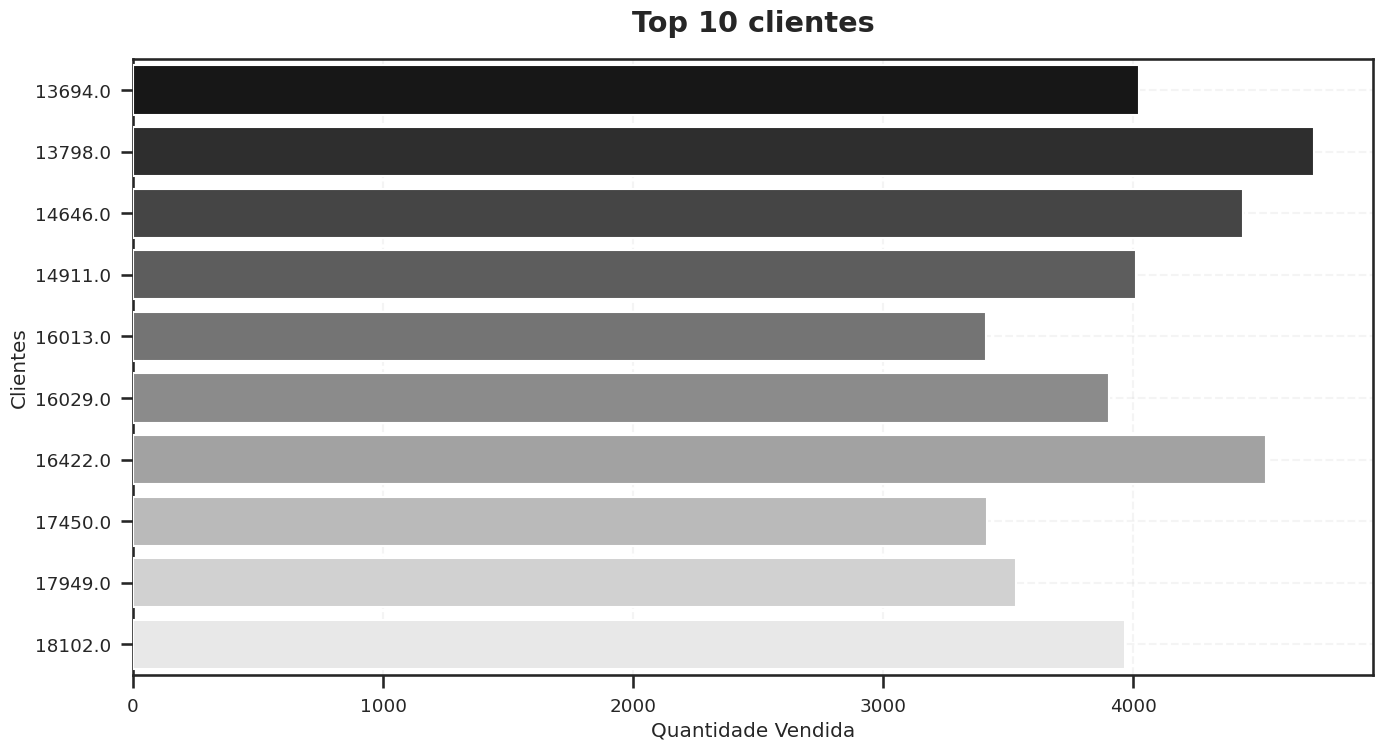

In [179]:


create_horizontal_barplot(topclientespedidos, x_col='total_pedidos', y_col='id_cliente', title="Top 10 clientes", xlabel="Quantidade Vendida", ylabel="Clientes")

In [180]:
# top 10 produtos em preco_total
topprodincome=top_product_income(df)
topprodincome.style.background_gradient(cmap='Reds')

,descricao,preco_total
1500,Manual,156141.750000
1925,REGENCY CAKESTAND 3 TIER,40398.400000
1683,PICNIC BASKET WICKER 60 PIECES,39619.500000
1807,POSTAGE,29181.090000
2611,WHITE HANGING HEART T-LIGHT HOLDER,15825.050000
2207,SET/4 WHITE RETRO STORAGE CUBES,15722.700000
1647,PARTY BUNTING,13890.300000
511,CHILLI LIGHTS,12583.940000
1828,RABBIT NIGHT LIGHT,10396.560000
712,DOORMAT KEEP CALM AND COME IN,8771.380000


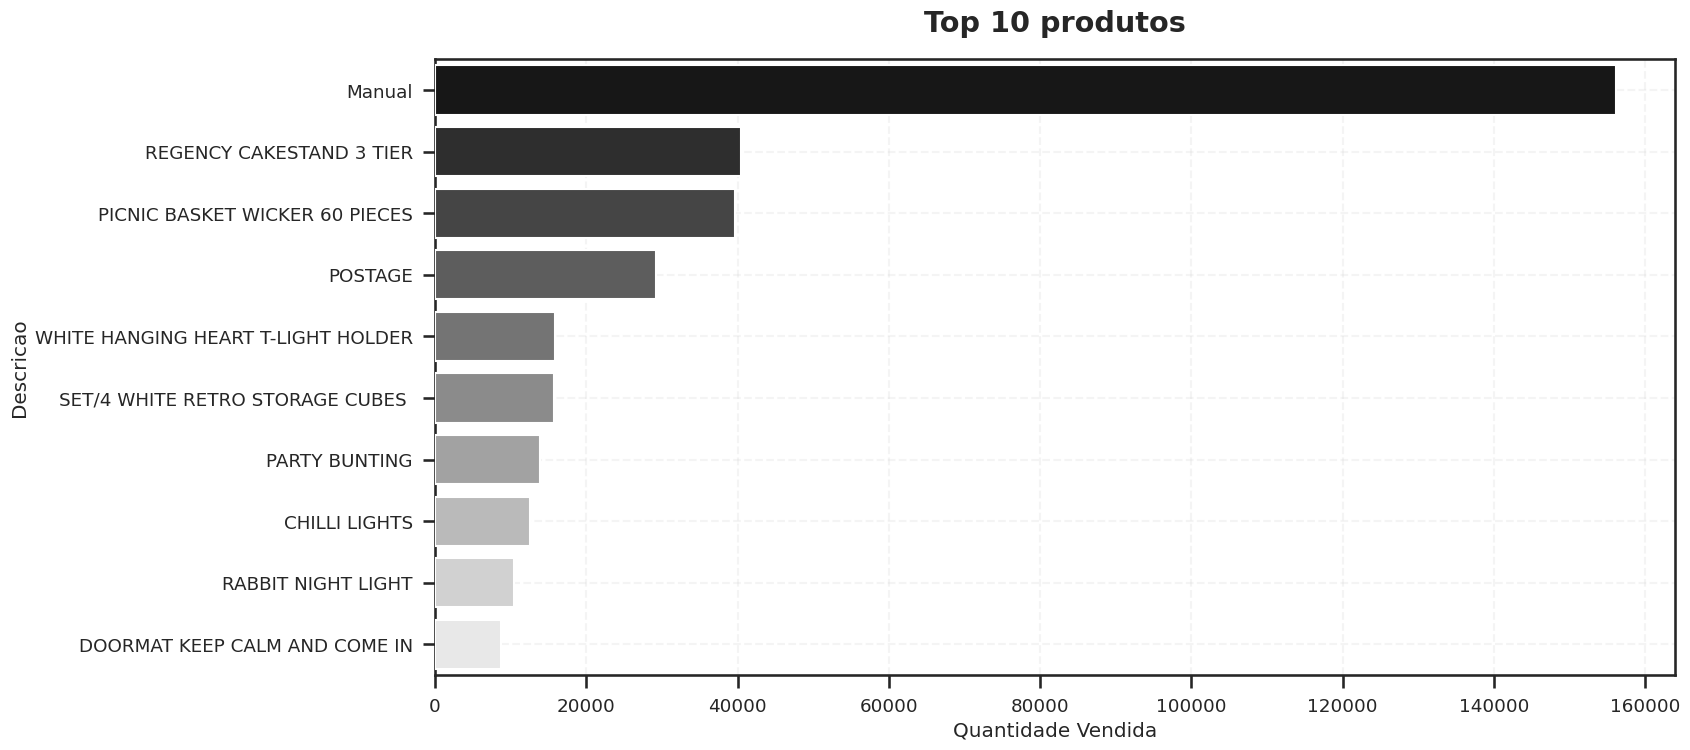

In [181]:
#grafico de  barras quantidades de vendas

create_horizontal_barplot(topprodincome, 'preco_total', 'descricao', title="Top 10 produtos", xlabel="Quantidade Vendida", ylabel="Descricao")

In [182]:
#top 10 produtos vendidos quantidade

topproductquant=top_product_quatity(df)

topproductquant.style.background_gradient(cmap='Reds')


,descricao,quantidade_vendida
2611,WHITE HANGING HEART T-LIGHT HOLDER,5942
1828,RABBIT NIGHT LIGHT,5714
1247,JUMBO BAG RED RETROSPOT,4050
1925,REGENCY CAKESTAND 3 TIER,3618
2493,VICTORIAN GLASS HANGING T-LIGHT,3491
1647,PARTY BUNTING,3222
136,ANTIQUE SILVER T-LIGHT GLASS,3132
1623,PAPER CHAIN KIT 50'S CHRISTMAS,3062
1500,Manual,3018
151,ASSORTED COLOUR BIRD ORNAMENT,2982


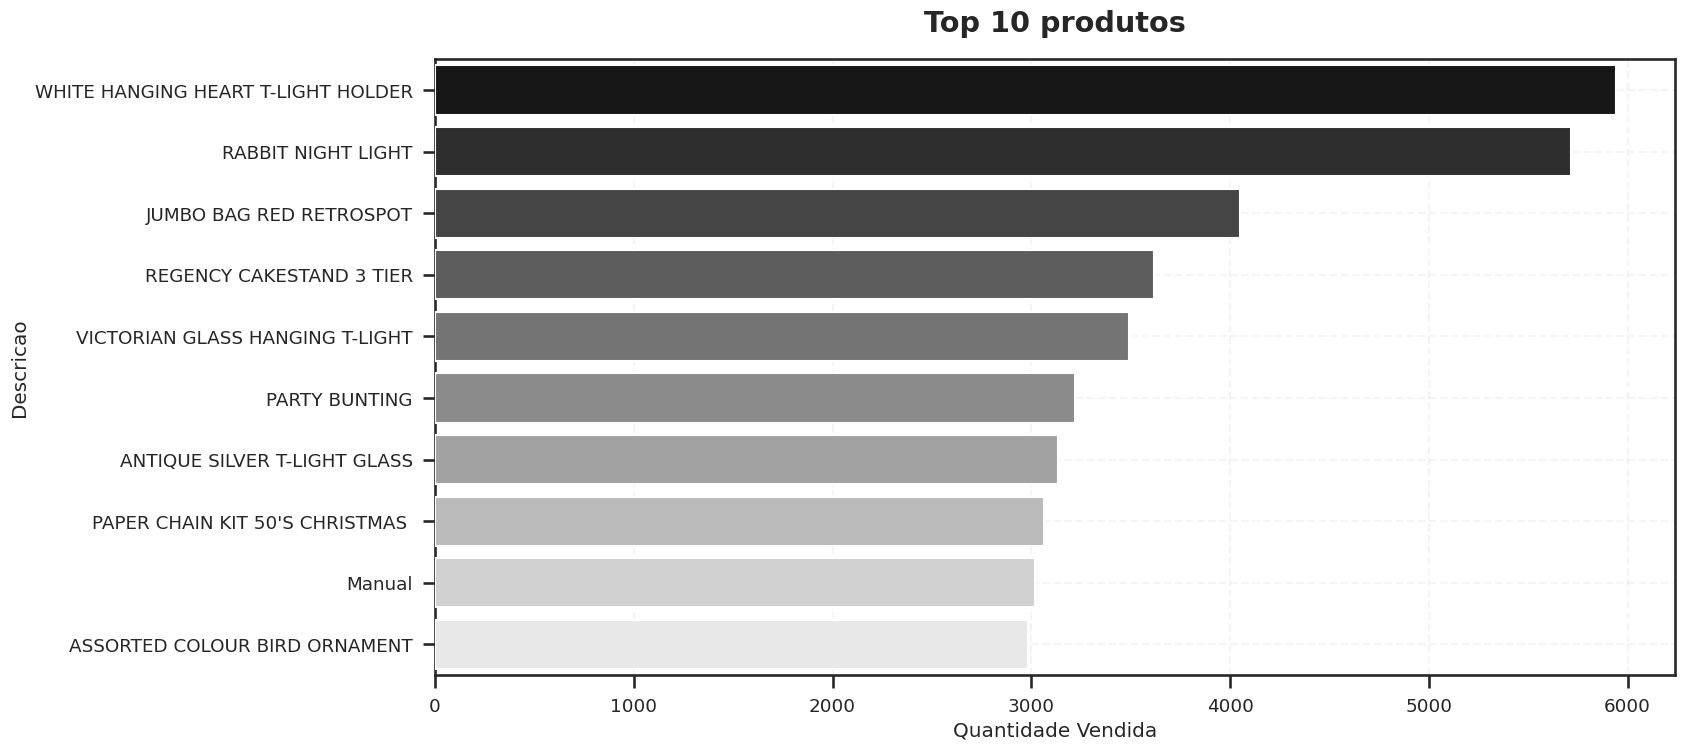

In [183]:


create_horizontal_barplot(topproductquant, 'quantidade_vendida', 'descricao', title="Top 10 produtos", xlabel="Quantidade Vendida", ylabel="Descricao")

#  Data Preparation

Como analisado acima antes de clusterizar precisamos tratar os dados.

Vamos experiemtar dois tipos de preprocessamento um com transformacao logaritmica e depois um Scaler
 e o segundo apenas um scaler, entendendo que ambos precisam de retirar outliers, porem
como o dataset sao apresentam muitos dados, o metodo utilizado vai ser clipando("forçando") os nossos dados para dentro de desvio padrao de 3

<Axes: >

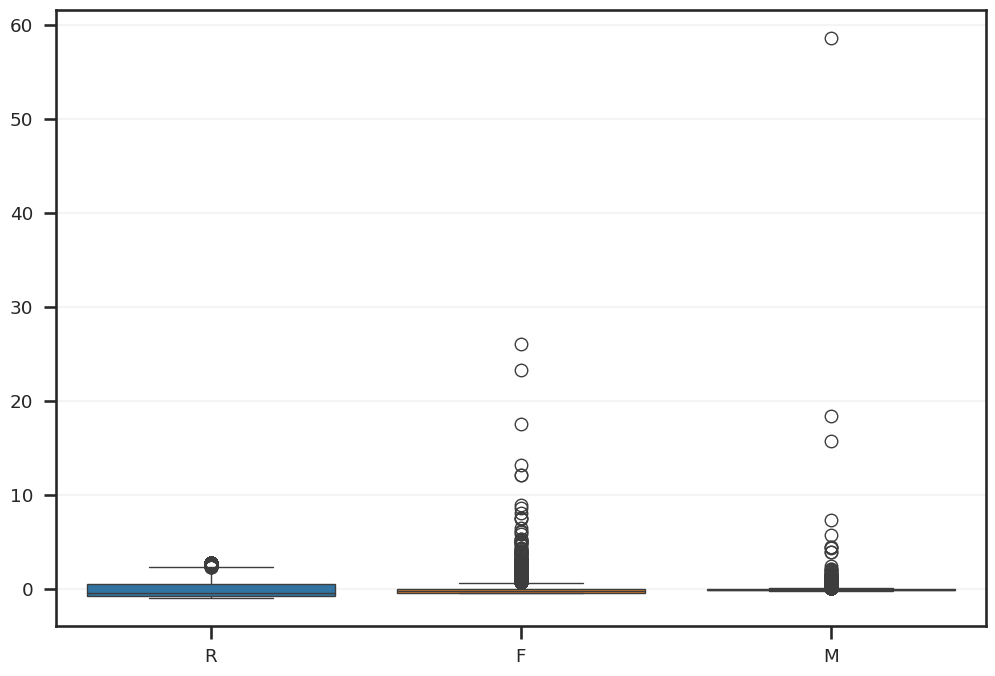

In [184]:
# transformacao usando apenas scale
rfm_scale=rfm.apply(scale).copy()
sns.boxplot(rfm_scale)

<Axes: >

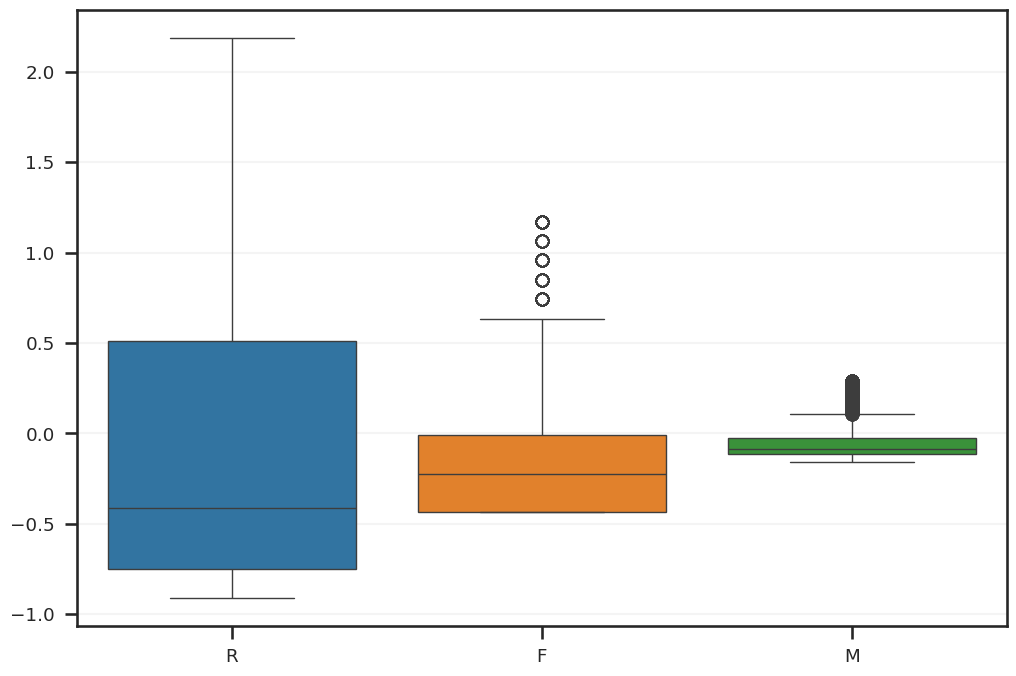

In [185]:
#usando metodo clip para evitar para o dados com scaling apenas
# trazendo para dentro de 3 desvios padroes
rfm_scale_trans = rfm_scale.apply(lambda x: x.clip(upper=x.quantile(0.95)))
sns.boxplot(rfm_scale_trans)

<Axes: >

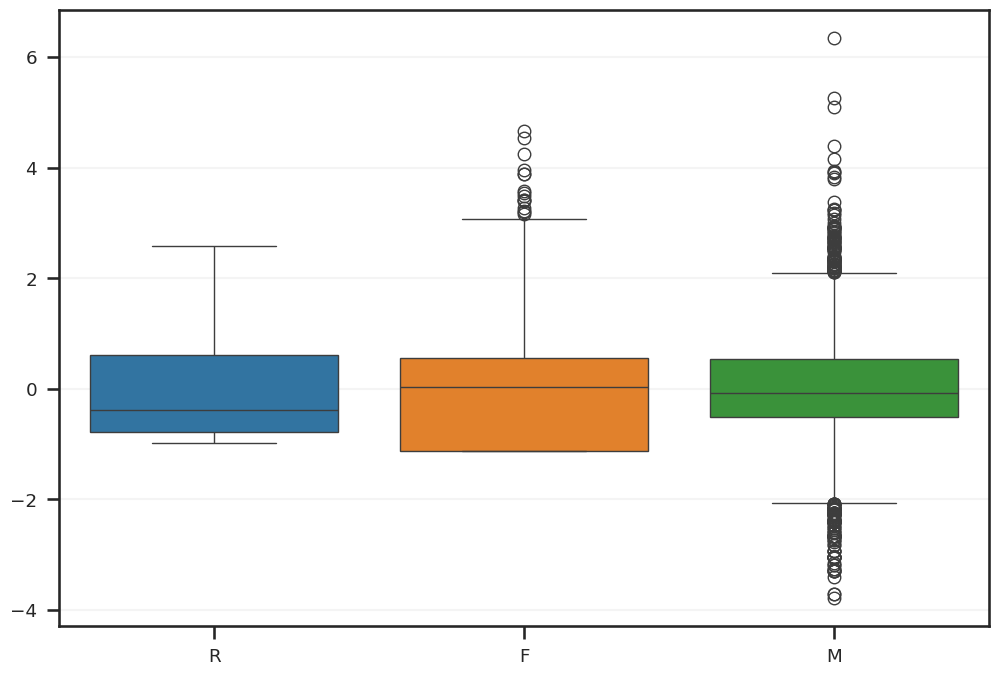

In [186]:
#transformando em log e padronizando
rfm_log_scale=rfm.apply(np.log).apply(scale)
sns.boxplot(rfm_log_scale)

<Axes: >

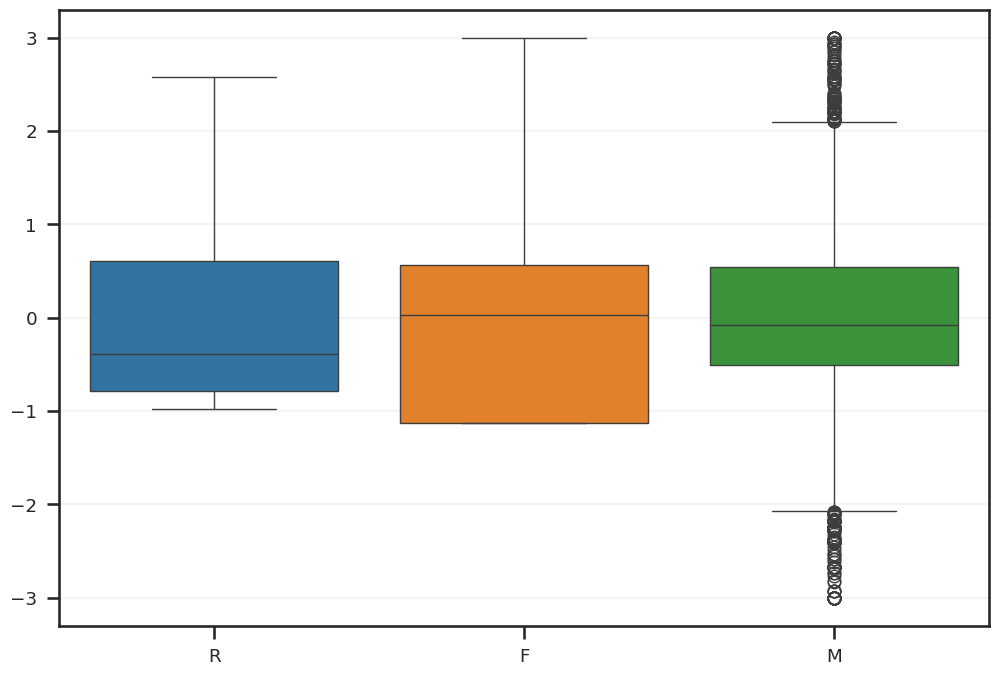

In [187]:
# trazendo para dentro de 3 desvios padroes
rfm_log_trans = rfm_log_scale.apply(lambda x: x.clip(lower=x.mean()-x.std()*3, upper=x.mean()+x.std()*3))
sns.boxplot(rfm_log_trans)

# Modeling & Evaluation

## Kmeans para RFM_SCALE

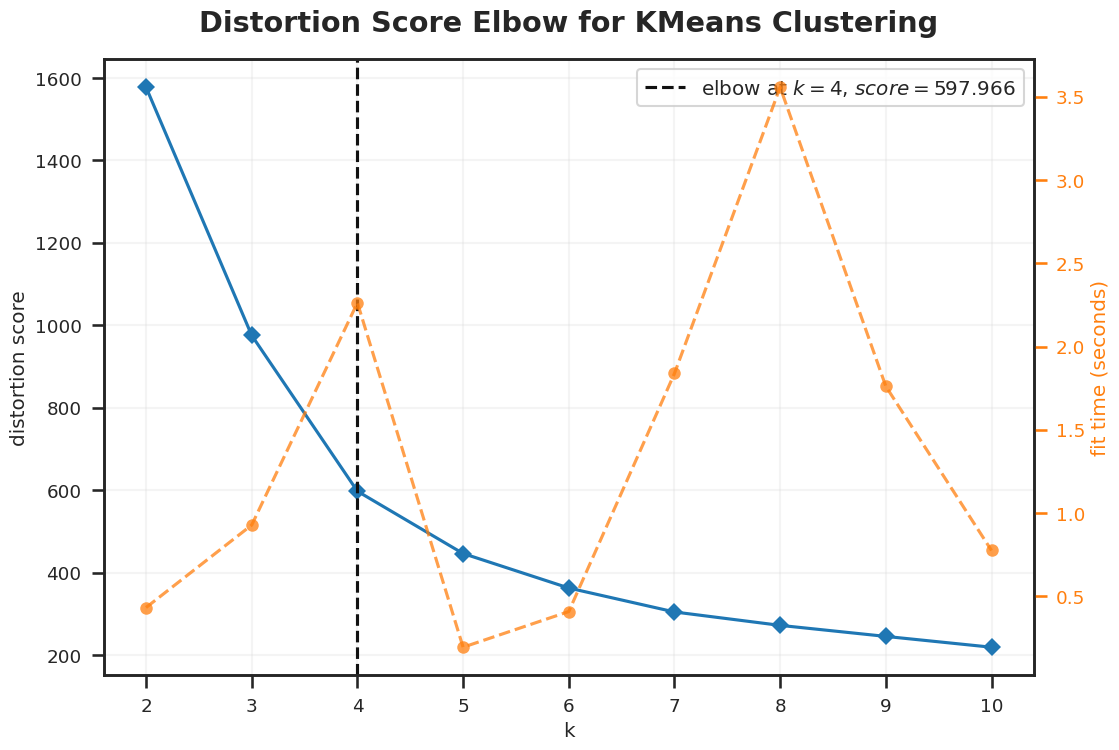

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10))

In [188]:
kelbow_visualizer(KMeans(), rfm_scale_trans, k=10)

In [189]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, n_init='auto', random_state=2023)
  labels = model.fit_predict(rfm_scale_trans)
  cluster_results_dict = {'k':k}
  cluster_results_dict['inertia'] = model.inertia_

  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(rfm_scale_trans, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='Reds')

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,1577.572168,0.624080,0.543873,9233.932923
3,1113.245153,0.403652,0.852862,7452.041037
4,597.879797,0.515721,0.626406,10502.920776
5,446.968056,0.449855,0.736584,10903.132493
6,364.178705,0.428759,0.748123,10902.090731
7,305.922836,0.413527,0.765526,10950.277782
8,272.846760,0.397454,0.817392,10597.445669
9,246.496478,0.404785,0.820122,10319.524968
10,222.935809,0.382644,0.865916,10191.298153


In [190]:
x=rfm_scale_trans

model=KMeans(n_clusters=4, random_state=101)
model.fit_predict(x)

array([1, 0, 0, ..., 0, 2, 0], dtype=int32)

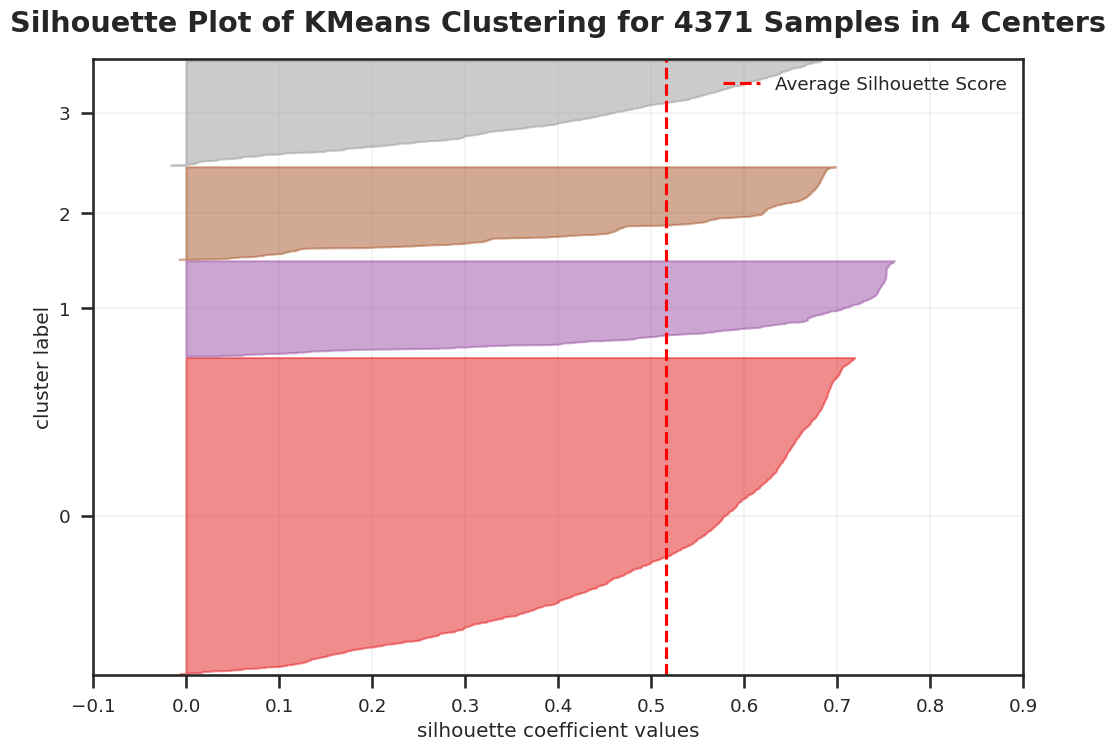

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4371 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4, random_state=101))

In [191]:
silhouette_visualizer(model, x)

In [220]:
labels = model.fit_predict(rfm_scale_trans).astype(str)
centers=model.cluster_centers_

In [193]:
px.scatter_3d(data_frame=rfm_scale_trans, x='R', y='F', z='M', color=labels, template='plotly_dark')

## AgglomerativeClsutering RFM_SCALE

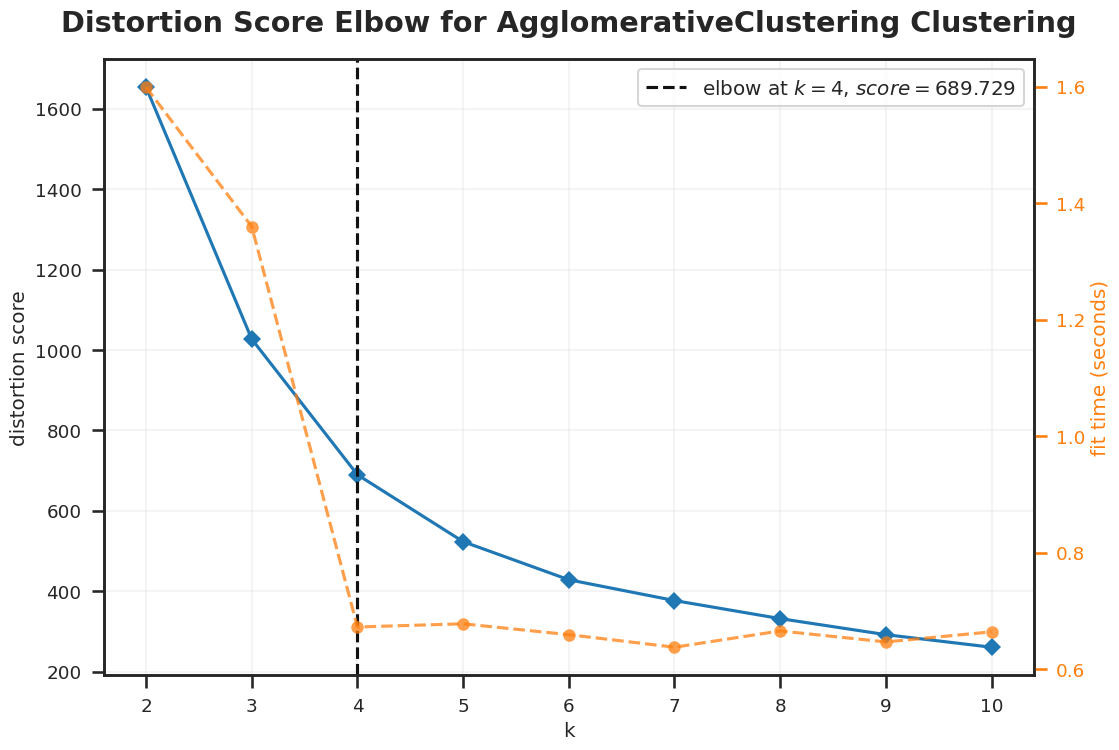

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10))

In [194]:
kelbow_visualizer(AgglomerativeClustering(), x, k=10, timing=False)

In [195]:
cluster_metrics= silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results=[]
x=rfm_scale_trans
#cluster_results_dict["inertia"]= model.inertia_
for k in range (2,11):
  model=AgglomerativeClustering(n_clusters=k)
  labels=model.fit_predict(x)
  cluster_results_dict={"k": k}
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__]= metric(x, labels)
  cluster_metrics_results.append(cluster_results_dict)

cluster_metrics_results

pd.DataFrame(cluster_metrics_results).set_index("k").style.background_gradient(axis=0)

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.624933,0.494617,8607.915033
3,0.503863,0.639815,8260.646771
4,0.460093,0.688800,8910.407557
5,0.454343,0.687851,9152.940503
6,0.377322,0.856598,9134.073696
7,0.357761,0.863166,8754.876059
8,0.347854,0.871650,8603.167400
9,0.324682,0.877135,8630.163691
10,0.337164,0.856920,8646.713725


In [196]:
model_hclust=AgglomerativeClustering(n_clusters=4)
hclust_labels=model_hclust.fit_predict(x)
hclust_labels


array([0, 1, 3, ..., 1, 2, 1])

In [197]:
px.scatter_3d(data_frame=rfm_scale_trans, x='R', y='F', z='M', color=hclust_labels.astype("str"), template='plotly_dark')

In [198]:
print(silhouette_score(rfm_scale_trans, hclust_labels))

0.46009322080617715


# Kmeans RFM_LOG

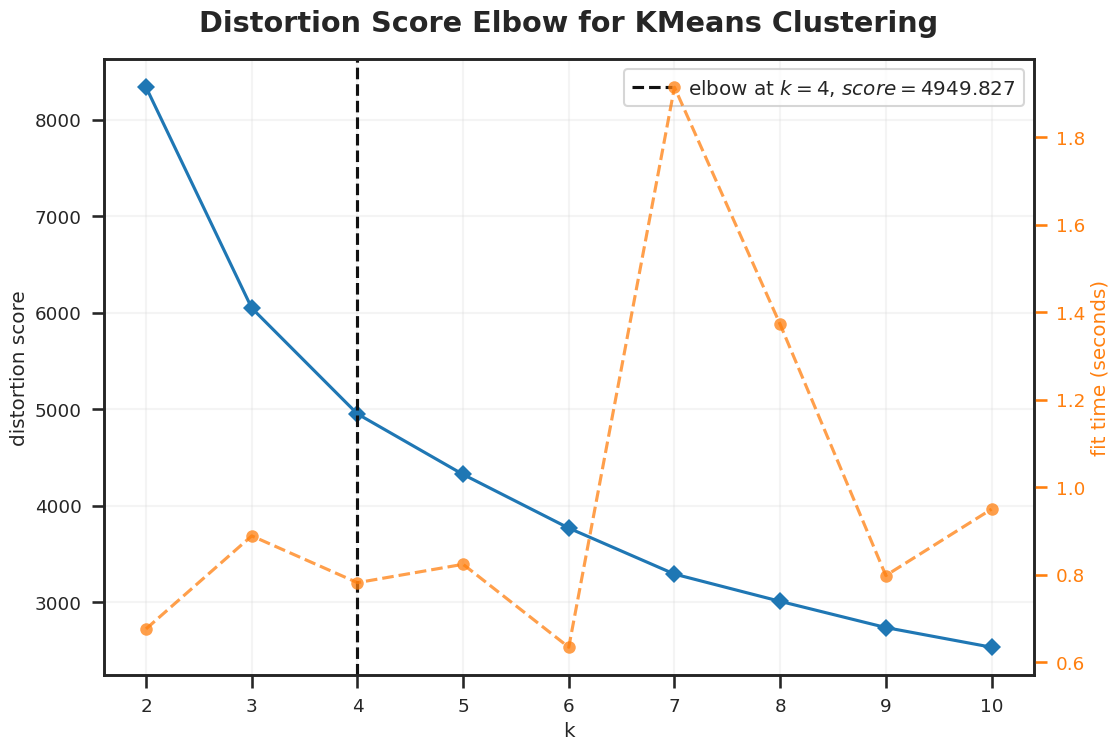

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10))

In [199]:
kelbow_visualizer(KMeans(), rfm_log_trans, k=10)

In [200]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, n_init='auto', random_state=2023)
  labels = model.fit_predict(rfm_log_trans)
  cluster_results_dict = {'k':k}
  cluster_results_dict['inertia'] = model.inertia_

  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(rfm_scale_trans, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='Reds')

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8337.204270,0.323848,1.074678,2867.997818
3,6047.342236,0.333401,1.044786,6092.696742
4,4949.858774,0.272209,1.456192,3997.678641
5,4322.543804,0.194411,1.396533,3270.651405
6,3816.366654,0.136019,3.103598,3562.075766
7,3289.094205,0.087720,3.752385,2956.496567
8,3084.417820,0.065333,4.078225,2619.566757
9,2787.150707,0.090558,4.217640,2967.914883
10,2594.799322,0.048541,4.429739,2727.317096


In [201]:
x_log=rfm_log_trans

model=KMeans(n_clusters=4, random_state=101)
model.fit_predict(x_log)

array([0, 1, 3, ..., 2, 1, 2], dtype=int32)

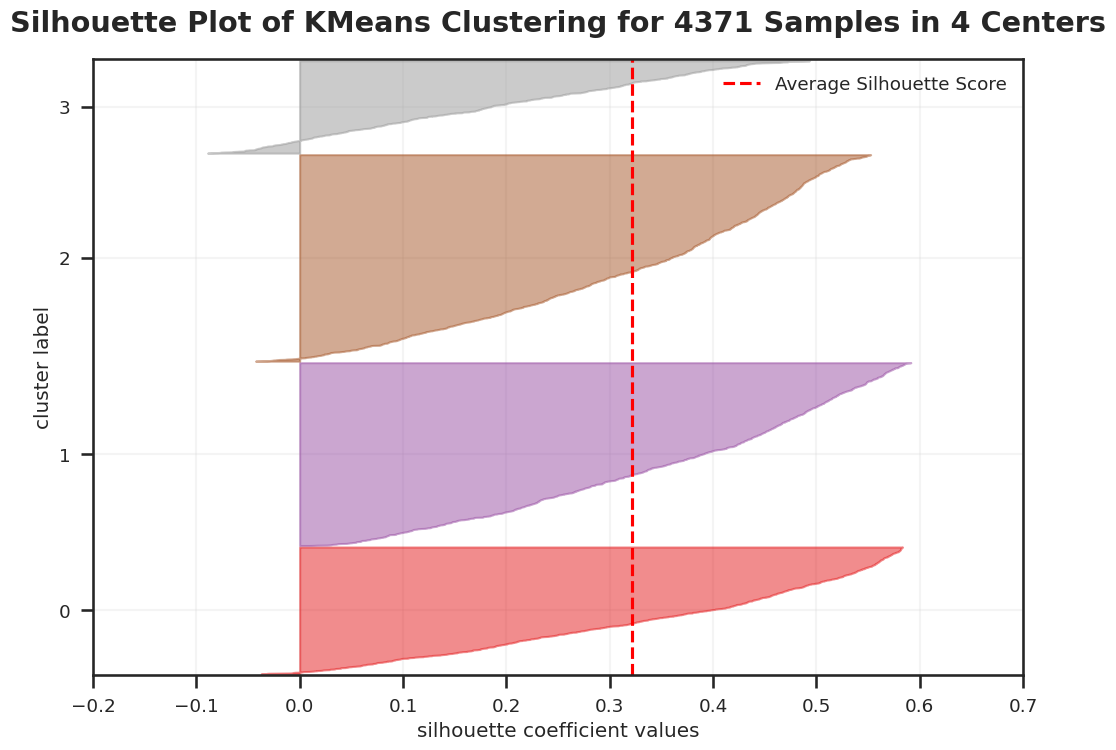

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4371 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4, random_state=101))

In [202]:
silhouette_visualizer(model, x_log)

In [203]:
labels_log = model.fit_predict(x_log).astype(str)
center_log=model.cluster_centers_

In [204]:
print(silhouette_score(x_log, labels_log))

0.32125333192843153


In [205]:
px.scatter_3d(x_log,  x='R', y='F', z='M', color=labels_log,template='plotly_dark' )

## AgglomerativeClustering RFM_LOG

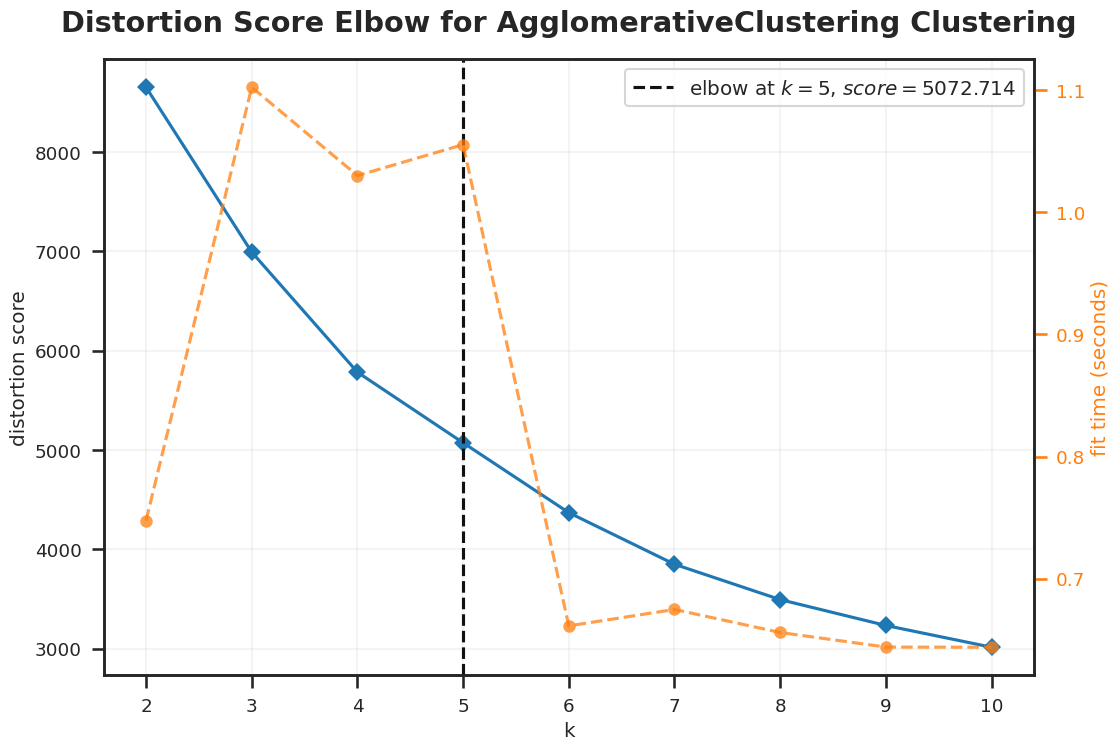

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10))

In [206]:
kelbow_visualizer(AgglomerativeClustering(), x_log, k=10)

In [207]:
model_hclust_log=AgglomerativeClustering(n_clusters=5)
hclust_labels_log=model_hclust_log.fit_predict(x_log)
hclust_labels_log

array([0, 2, 1, ..., 1, 2, 1])

In [208]:
px.scatter_3d(data_frame=x_log, x='R', y='F', z='M', color=hclust_labels_log, template='plotly_dark')

# Modelo Escolhido KMeans usando rfm_scaled

In [209]:
centers= pd.DataFrame(model.cluster_centers_, columns=rfm_scale.columns)
centers

,R,F,M
0,1.619792,-0.791610,-0.313899
1,-0.695669,1.183274,0.247998
2,-0.405425,-0.478262,-0.622218
3,0.056253,-0.201220,1.306095


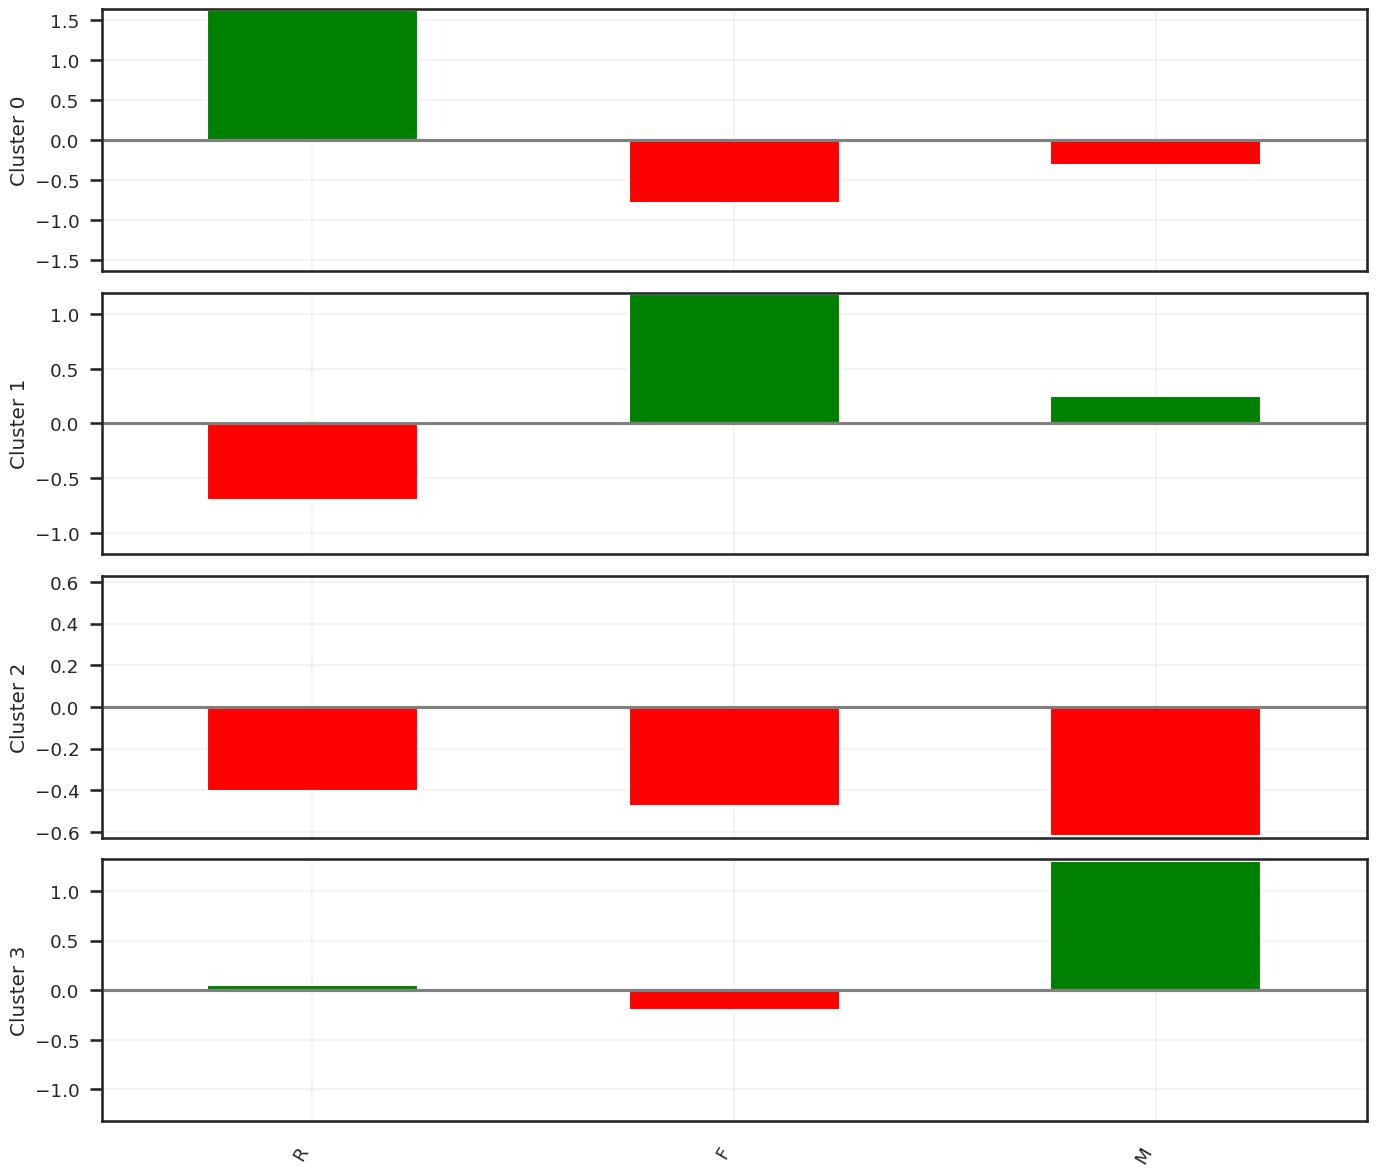

In [211]:
#plotando grafico para analisar os clusters
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


In [223]:
labels=pd.DataFrame(labels)

labels.value_counts(normalize=True)*100

0    51.956074
3    17.181423
1    15.648593
2    15.213910
dtype: float64